In [10]:
# basic 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)
from itertools import combinations

# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#  tf.logging.set_verbosity(tf.logging.ERROR) <- logging이 버전업그레이드에서 사용 X라함

# from tensorflow import set_random_seed 
# 위에 코드 안됨에 대한 답변: In Tensoflow2 there is no need to perform
# from tensorflow import set_random_seed
# in order to run
# set_random_seed(x)
# (as it was in older version)
# Only have to run
# import tensorflow
# tensorflow.random.set_seed(x)

tf.random.set_seed(2020)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.preprocessing.text import *

### Read Data

In [6]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

### Transform Data

In [7]:
#df_train.goods_id.nunique(), df_train.gds_grp_nm.nunique(), df_train.gds_grp_mclas_nm.nunique()
#df_train.store_nm.astype('category').cat.codes
#pd.to_datetime(df_train.tran_date).dt.weekday

max_features = 100000
max_len = 100
emb_dim = 128

##### low level: goods_id

In [11]:
# Converts a "goods_id" to a sequence of indexes in a fixed-size hashing space
df_train.goods_id = df_train.goods_id.apply(lambda x: str(x))
df_test.goods_id = df_test.goods_id.apply(lambda x: str(x))
X_train = df_train.groupby('cust_id')['goods_id'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['goods_id'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values

# Pads sequences to the same length
X_train_low = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_low = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_low.shape, X_test_low.shape

((3500, 100), (2482, 100))

##### middle level: gds_grp_nm

In [12]:
# Converts a "gds_grp_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features//10)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features//10)[0] for i in x]).values

# Pads sequences to the same length
X_train_mid = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_mid = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_mid.shape, X_test_mid.shape

((3500, 100), (2482, 100))

##### high level: gds_grp_mclas_nm

In [13]:
# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values

# Pads sequences to the same length
X_train_high = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_high = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_high.shape, X_test_high.shape

((3500, 100), (2482, 100))

##### store

In [14]:
# Converts a "store_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['store_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['store_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values

# Pads sequences to the same length
X_train_str = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_str = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_str.shape, X_test_str.shape

((3500, 100), (2482, 100))

##### weekday

In [15]:
# Converts a "tran_date" to a sequence of indexes in a fixed-size hashing space
df_train.tran_date = pd.to_datetime(df_train.tran_date).dt.weekday
df_test.tran_date = pd.to_datetime(df_test.tran_date).dt.weekday
X_train = df_train.groupby('cust_id')['tran_date'].apply(lambda x: list(x)).values
X_test = df_test.groupby('cust_id')['tran_date'].apply(lambda x: list(x)).values

# Pads sequences to the same length
X_train_day = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_day = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_day.shape, X_test_day.shape

((3500, 100), (2482, 100))

summation data

In [30]:
X_train = pd.DataFrame(np.hstack([X_train_low, X_train_mid,X_train_high, X_train_str,X_train_day]))
X_test = pd.DataFrame(np.hstack([X_test_low, X_test_mid,X_test_high, X_test_str,X_test_day]))

X_train.shape, X_test.shape

((3500, 500), (2482, 500))

In [33]:
#df_train.goods_id.nunique(), df_train.gds_grp_nm.nunique(), df_train.gds_grp_mclas_nm.nunique()
#df_train.store_nm.astype('category').cat.codes
#pd.to_datetime(df_train.tran_date).dt.weekday

max_features = 100000
max_len = 100
emb_dim = 128

In [27]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,1,3,3,3,6,6,6,6,6,6,6,0,0,0,0,5,5,5,5,5,5,5,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,1,1,1,3,3,1,1,1,6,6,6,6,0,0,6,1,0,0,0,5,3,3,4
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6
3496,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,4,0,5,1,1,1,5,5,6,5,5,3,3
3497,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3


test DNN -> 0.56 ~ 0.65

test CNN

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
all (InputLayer)             (None, 500)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 500, 128)          12800000  
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 498, 32)           12320     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 249, 32)           0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 249, 32)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 247, 32)           3104      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 32)                0   

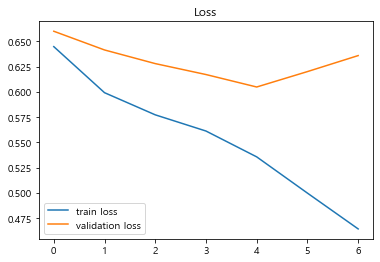

In [40]:
# Define the Model & its Architecture
in_all = Input(shape=(max_len,), dtype='int32', name='all')
x = Embedding(max_features, emb_dim)(in_all)
x = Conv1D(32, 3, activation='elu')(x)
#x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.5)(x)
x = Conv1D(32, 3, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_all = Dropout(0.5)(x)


out = Dense(1, activation='sigmoid')(x)

model = Model(in_all, out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
# Train the Model
history = model.fit(train_x, train_y, epochs=50, batch_size=64, 
                    validation_data=(valid_x, valid_y), callbacks=[EarlyStopping(patience=2)])

print(roc_auc_score(valid_y, model.predict(valid_x)))

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

test CNN again

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
low (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
mid (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
high (InputLayer)               (None, 100)          0                                            
__________________________________________________________________________________________________
store (InputLayer)              (None, 100)          0                                            
____________________________________________________________________________________________

Train on 2800 samples, validate on 700 samples
Epoch 1/6
2800/2800 [==============================] - 9s 3ms/step - loss: 0.6460 - acc: 0.6275 - val_loss: 0.6413 - val_acc: 0.6271
Epoch 2/6
2800/2800 [==============================] - 8s 3ms/step - loss: 0.6361 - acc: 0.6246 - val_loss: 0.6352 - val_acc: 0.6371
Epoch 3/6
2800/2800 [==============================] - 8s 3ms/step - loss: 0.6259 - acc: 0.6436 - val_loss: 0.6299 - val_acc: 0.6371
Epoch 4/6
2800/2800 [==============================] - 8s 3ms/step - loss: 0.6227 - acc: 0.6375 - val_loss: 0.6257 - val_acc: 0.6471
Epoch 5/6
2800/2800 [==============================] - 8s 3ms/step - loss: 0.6136 - acc: 0.6482 - val_loss: 0.6207 - val_acc: 0.6557
Epoch 6/6
2800/2800 [==============================] - 8s 3ms/step - loss: 0.6055 - acc: 0.6575 - val_loss: 0.6161 - val_acc: 0.6586
0.7206018557177372


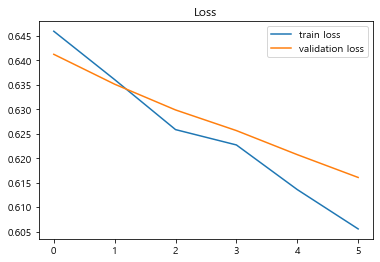

In [49]:
# Define the Model & its Architecture
in_low = Input(shape=(max_len,), dtype='int32', name='low')
x = Embedding(max_features, emb_dim)(in_low)
x = Conv1D(32, 5, activation='elu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(32, 5, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_low = Dropout(0.5)(x)

in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
x = Embedding(max_features//10, emb_dim)(in_mid)
x = Conv1D(32, 3, activation='elu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(32, 3, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_mid = Dropout(0.5)(x)

in_high = Input(shape=(max_len,), dtype='int32', name='high')
x = Embedding(max_features//100, emb_dim)(in_high)
x = Conv1D(32, 1, activation='elu')(x)
x = MaxPooling1D(1)(x)
x = Conv1D(32, 1, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_high = Dropout(0.5)(x)

in_str = Input(shape=(max_len,), dtype='int32', name='store')
x = Embedding(max_features//100, emb_dim)(in_str)
x = Conv1D(32, 1, activation='elu')(x)
x = MaxPooling1D(1)(x)
x = Conv1D(32, 1, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_str = Dropout(0.5)(x)

in_day = Input(shape=(max_len,), dtype='int32', name='day')
x = Embedding(7, emb_dim)(in_day)
x = Conv1D(32, 1, activation='elu')(x)
x = MaxPooling1D(1)(x)
x = Conv1D(32, 1, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_day = Dropout(0.5)(x)

x = add([out_low, out_mid, out_high, out_str, out_day], name='my_layer')
out = Dense(1, activation='sigmoid')(x)

model = Model([in_low, in_mid, in_high, in_str, in_day], out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit([X_train_low, X_train_mid, X_train_high, X_train_str, X_train_day], y_train, epochs=6, batch_size=64, 
                    validation_split=0.2, callbacks=[EarlyStopping(patience=7)])

print(roc_auc_score(y_train, model.predict([X_train_low, X_train_mid, X_train_high, X_train_str, X_train_day])))

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

test LSTM

### Transform Data

In [41]:
max_features = 100000
max_len = 100
emb_dim = 128

##### low level: goods_id

In [42]:
# Converts a "goods_id" to a sequence of indexes in a fixed-size hashing space
df_train.goods_id = df_train.goods_id.apply(lambda x: str(x))
df_test.goods_id = df_test.goods_id.apply(lambda x: str(x))
X_train = df_train.groupby('cust_id')['goods_id'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['goods_id'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values

# Pads sequences to the same length
X_train_low = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_low = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_low.shape, X_test_low.shape

((3500, 100), (2482, 100))

##### middle level: gds_grp_nm

In [43]:
# Converts a "gds_grp_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features//10)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features//10)[0] for i in x]).values

# Pads sequences to the same length
X_train_mid = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_mid = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_mid.shape, X_test_mid.shape

((3500, 100), (2482, 100))

##### high level: gds_grp_mclas_nm

In [44]:
# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values

# Pads sequences to the same length
X_train_high = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_high = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_high.shape, X_test_high.shape

((3500, 100), (2482, 100))

### Build Bidirectional LSTMs

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
low (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
mid (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
high (InputLayer)               (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 100, 128)     12800000    low[0][0]                        
____________________________________________________________________________________________

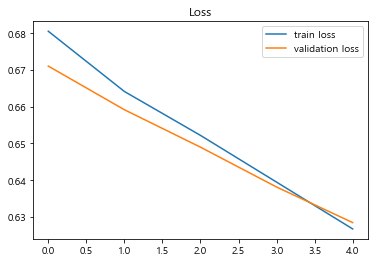

In [46]:
# Define the Model & its Architecture
in_low = Input(shape=(max_len,), dtype='int32', name='low')
x = Embedding(max_features, emb_dim)(in_low)
out_low = Bidirectional(LSTM(16))(x)

in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
x = Embedding(max_features//10, emb_dim)(in_mid)
out_mid = Bidirectional(LSTM(16))(x)

in_high = Input(shape=(max_len,), dtype='int32', name='high')
x = Embedding(max_features//100, emb_dim)(in_high)
out_high = Bidirectional(LSTM(16))(x)

x = concatenate([out_low, out_mid, out_high], name='my_layer')
out = Dense(1, activation='sigmoid')(x)

model = Model([in_low, in_mid, in_high], out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit([X_train_low, X_train_mid, X_train_high], y_train, epochs=5, batch_size=64, 
                    validation_split=0.2, callbacks=[EarlyStopping(patience=5)])

print(roc_auc_score(y_train, model.predict([X_train_low, X_train_mid, X_train_high])))

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

In [50]:
X_train = pd.read_csv('X_test_after_percentile_nm&mclas.csv',encoding='cp949')
X_test = pd.read_csv('X_test_after_percentile_nm&mclas.csv',encoding='cp949')

In [51]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265
0,6.720856e-02,0.042145,3.624360e-02,0.043737,0.049043,3.638836e-02,2.225512e-02,0.043864,0.046939,0.047247,3.672420e-02,0.052970,0.032652,0.042611,0.029854,0.038975,0.041701,0.027953,6.054522e-02,0.036375,2.744886e-02,0.027893,0.040317,3.533241e-02,3.900481e-02,...,-0.078783,-0.015705,-0.070130,0.104986,-0.087078,-0.026219,-0.091528,-0.016858,0.028914,-0.066299,-0.014294,0.034225,-0.051002,0.022624,-0.008437,0.017275,0.012446,-0.052215,-0.019227,-0.114905,0.121020,-0.017553,0.161887,-0.071814,-0.004024
1,5.353416e-02,0.074409,4.255105e-02,0.038985,0.073937,4.231464e-02,5.450580e-02,0.036693,0.034345,0.034598,3.797293e-02,0.050380,0.025835,0.048371,0.039852,0.052264,0.039762,0.036755,3.911033e-02,0.031253,4.213731e-02,0.030002,0.056388,3.503751e-02,3.628049e-02,...,-0.096042,0.000898,-0.063846,0.084214,-0.095974,-0.070154,-0.041530,-0.042055,-0.117423,-0.092343,-0.037317,0.009548,-0.045925,-0.025983,0.020410,0.018712,0.011218,-0.041737,-0.112703,0.226192,0.087743,0.326348,0.025749,0.131011,0.034408
2,5.311731e-02,0.041534,4.332975e-02,0.044375,0.039704,3.962666e-02,4.192009e-02,0.043751,0.041240,0.044299,4.419534e-02,0.044535,0.033264,0.047472,0.047831,0.044416,0.047909,0.036949,4.308294e-02,0.027224,4.872717e-02,0.033952,0.040696,3.075889e-02,3.061089e-02,...,-0.094258,-0.000912,-0.034913,0.093483,-0.040156,-0.019092,0.005699,-0.042454,-0.123784,-0.084773,-0.028194,0.059326,-0.050264,0.011243,0.019398,0.020408,-0.017388,-0.028387,-0.025638,0.324469,0.232713,0.325795,0.156143,0.204108,0.139712
3,4.113057e-02,0.064852,4.754248e-02,0.041295,0.069944,5.052356e-02,5.514720e-02,0.045604,0.064742,0.041495,4.955265e-02,0.039412,0.051891,0.049352,0.044680,0.053034,0.038611,0.061254,3.943272e-02,0.053118,3.650822e-02,0.051762,0.054078,4.298509e-02,4.325961e-02,...,-0.088447,0.013541,-0.061657,0.062981,-0.076516,0.005572,-0.048722,-0.002061,-0.040813,-0.089504,-0.033022,0.043820,-0.011709,0.010612,-0.051576,0.037105,-0.032151,0.031008,0.000131,0.162965,-0.042897,0.217256,-0.080766,0.054245,-0.034014
4,5.439314e-02,0.043583,4.510792e-02,0.053774,0.033458,4.519232e-02,4.023671e-02,0.047995,0.029674,0.060926,4.244117e-02,0.041576,0.022459,0.022361,0.038346,0.033120,0.020158,0.026132,3.383551e-02,0.017740,3.844339e-02,0.030508,0.030441,2.416564e-02,3.334504e-02,...,-0.078274,-0.011854,-0.040545,0.085186,-0.067765,-0.007751,0.026868,-0.031092,-0.089362,-0.063299,-0.012518,0.032725,-0.045640,0.011930,-0.002422,0.019902,-0.015711,-0.036049,-0.037758,0.256876,0.174835,0.281329,0.115436,0.202430,0.080326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,4.637539e-02,0.030179,4.605711e-02,0.045967,0.037490,4.745286e-02,3.333072e-02,0.031836,0.023273,0.031561,4.067503e-02,0.046175,0.041691,0.037972,0.031890,0.043433,0.062462,0.026598,6.079313e-02,0.039255,3.393309e-02,0.035049,0.026044,3.334117e-02,3.914359e-02,...,-0.058280,-0.026613,-0.066966,0.084405,-0.094837,-0.049232,-0.119595,-0.073820,0.004163,-0.063159,-0.060510,0.039405,-0.067871,-0.036443,-0.008320,0.010896,0.037790,-0.068629,-0.042366,0.069105,-0.095875,0.105212,0.027083,-0.030293,-0.061545
2478,3.725290e-09,0.000000,1.862645e-09,0.000000,0.000000,3.725290e-09,7.450581e-09,0.000000,0.000000,0.000000,3.725290e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.862645e-09,0.000000,1.862645e-09,0.000000,0.000000,2.328306e-10,7.450581e-09,...,-0.096247,-0.039116,-0.077144,0.095060,-0.105519,0.016244,-0.060533,0.025513,-0.057389,0.005176,0.022483,0.057059,-0.007926,0.010672,-0.052794,0.047730,-0.040079,0.039044,-0.079711,0.286647,-0.188201,0.319889,-0.318131,-0.032594,-0.157397
2479,4.952636e-02,0.046983,4.101980e-02,0.054742,0.044845,4.380448e-02

In [ ]:
# Define the Model & its Architecture
in_low = Input(shape=(max_len,), dtype='int32', name='low')
x = Embedding(max_features, emb_dim)(in_low)
out_low = Bidirectional(LSTM(16))(x)

in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
x = Embedding(max_features//10, emb_dim)(in_mid)
out_mid = Bidirectional(LSTM(16))(x)

in_high = Input(shape=(max_len,), dtype='int32', name='high')
x = Embedding(max_features//100, emb_dim)(in_high)
out_high = Bidirectional(LSTM(16))(x)

x = concatenate([out_low, out_mid, out_high], name='my_layer')
out = Dense(1, activation='sigmoid')(x)

model = Model([in_low, in_mid, in_high], out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit([X_train_low, X_train_mid, X_train_high], y_train, epochs=5, batch_size=64, 
                    validation_split=0.2, callbacks=[EarlyStopping(patience=5)])

print(roc_auc_score(y_train, model.predict([X_train_low, X_train_mid, X_train_high])))

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

In [74]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(1,2,X_train.shape[1])))
model.add(Dense(16, activation='elu'))
model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(X_train, y_train)

ValueError: Input 0 is incompatible with layer bidirectional_22: expected ndim=3, found ndim=4

In [60]:
model = Sequential()
model.add(Bidirectional(LSTM(128, input_shape = (X_train.shape[1],))))
model.add(BatchNormalization())
model.add(Dense(128, input_shape = (X_train.shape[1],),activation = 'elu'))
model.add(Dense(64, activation = 'elu'))
model.add(Dense(5, activation = 'softmax'))
model.build(input_shape=(X_train.shape[1],))
model.compile(optimizer = 'adam', metrics = ['acc'], loss = 'categorical_crossentropy')
model.summary()

ValueError: Input 0 is incompatible with layer bidirectional_14: expected ndim=3, found ndim=1

In [75]:

# define LSTM
model = Sequential()
model.add(LSTM(20, input_shape=(10, 1), return_sequences=True))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [76]:
# fit model for one epoch on this sequence
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

ValueError: Error when checking input: expected lstm_26_input to have 3 dimensions, but got array with shape (2482, 266)

In [82]:
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
 
# create a sequence classification instance
def get_sequence(n_timesteps):
    # create a sequence of random numbers in [0,1]
    X = array([random() for _ in range(n_timesteps)])
    # calculate cut-off value to change class values
    limit = n_timesteps/4.0
    # determine the class outcome for each item in cumulative sequence
    y = array([0 if x < limit else 1 for x in cumsum(X)])
    # reshape input and output data to be suitable for LSTMs
    X = X.reshape(1, n_timesteps, 1)
    y = y.reshape(1, n_timesteps, 1)
    return X, y
 

In [83]:
# define problem properties
n_timesteps = 10
# define LSTM
model = Sequential()
model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# train LSTM
for epoch in range(1000):
    # generate new random sequence
    X,y = get_sequence(n_timesteps)
    # fit model for one epoch on this sequence
    model.fit(X, y, epochs=1, batch_size=1, verbose=2)
# evaluate LSTM
X,y = get_sequence(n_timesteps)
yhat = model.predict_classes(X, verbose=0)
for i in range(n_timesteps):
    print('Expected:', y[0, i], 'Predicted', yhat[0, i])

TypeError: 'module' object is not callable